In [ ]:
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
import seaborn as sns

#preprocessing
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

#model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn import metrics
from sklearn.svm import SVC

#eval
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from yellowbrick.model_selection import LearningCurve
from tensorflow.keras.callbacks import History


In [ ]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/cyberbullying_tweets/cyberbullying_tweets.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Preprocessing
X_train, X_test, y_train, y_test = train_test_split(data['tweet_text'], data['cyberbullying_type'], test_size=0.2, random_state=42)

# Text preprocessing
ps = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = ' '.join([ps.stem(word) for word in text.split() if word not in STOP_WORDS])
    return text

X_train = X_train.apply(clean_text)
X_train = X_train[X_train.str.split().str.len() >= 3]
y_train = y_train[X_train.index]

X_test = X_test.apply(clean_text)
X_test = X_test[X_test.str.split().str.len() >= 3]
y_test = y_test[X_test.index]

# Tokenization and Padding
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [ ]:
# RNN Model
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(SimpleRNN(units=50, activation='relu'))
model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
924/924 [==============================] - 53s 55ms/step - loss: 0.7435 - accuracy: 0.7059 - val_loss: 0.4539 - val_accuracy: 0.8129
Epoch 2/10
924/924 [==============================] - 38s 41ms/step - loss: 0.4394 - accuracy: 0.8275 - val_loss: 0.5099 - val_accuracy: 0.8050
Epoch 3/10
924/924 [==============================] - 38s 41ms/step - loss: 0.3441 - accuracy: 0.8660 - val_loss: 0.4382 - val_accuracy: 0.8225
Epoch 4/10
924/924 [==============================] - 37s 40ms/step - loss: 0.2783 - accuracy: 0.8891 - val_loss: 0.4661 - val_accuracy: 0.8186
Epoch 5/10
924/924 [==============================] - 37s 40ms/step - loss: 0.2369 - accuracy: 0.9038 - val_loss: 0.6704 - val_accuracy: 0.7764
Epoch 6/10
924/924 [==============================] - 38s 41ms/step - loss: 0.2062 - accuracy: 0.9183 - val_loss: 0.5467 - val_accuracy: 0.8053
Epoch 7/10
924/924 [==============================] - 39s 42ms/step - loss: 0.1776 - accuracy: 0.9281 - val_loss: 0.5695 - val_accuracy:

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test_categorical)
print(f"Test Accuracy: {accuracy}")

# Make predictions
predictions_prob_rnn = model.predict(X_test_pad)
predictions_rnn = np.argmax(predictions_prob_rnn, axis=1)

# Get class names from label encoder
class_names = label_encoder.classes_

# Model eval
print("RNN Classification Report:")
print(classification_report(y_test_encoded, predictions_rnn, target_names=class_names, digits=5))
print("ROC-AUC : ", round(roc_auc_score(y_test_categorical, predictions_prob_rnn, multi_class='ovr'), 5))

289/289 [==============================] - 3s 11ms/step


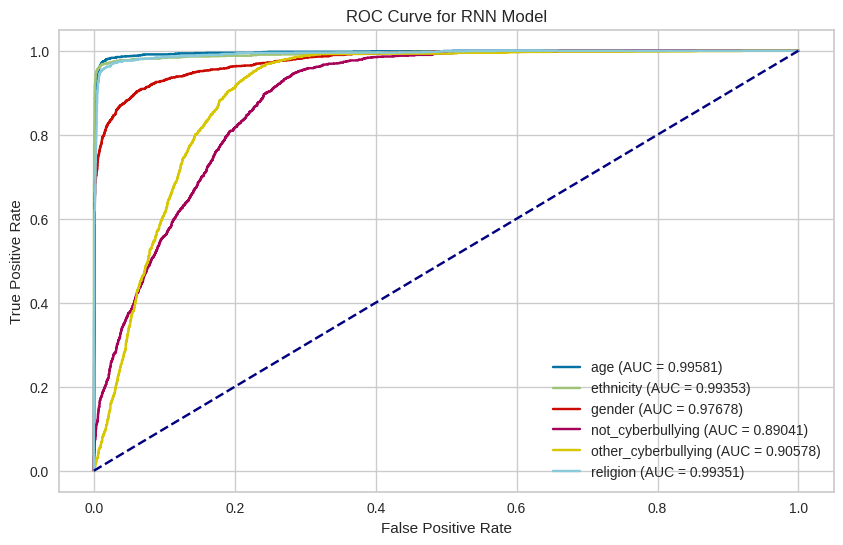

In [ ]:
# Make predictions
predictions_prob_rnn = model.predict(X_test_pad)

# Get class names from label encoder
class_names = label_encoder.classes_

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_categorical[:, i], predictions_prob_rnn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.5f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RNN Model')
plt.legend(loc="lower right")
plt.show()

289/289 [==============================] - 4s 13ms/step - loss: 0.7189 - accuracy: 0.8045
Test Accuracy: 0.8045341372489929
289/289 [==============================] - 3s 9ms/step


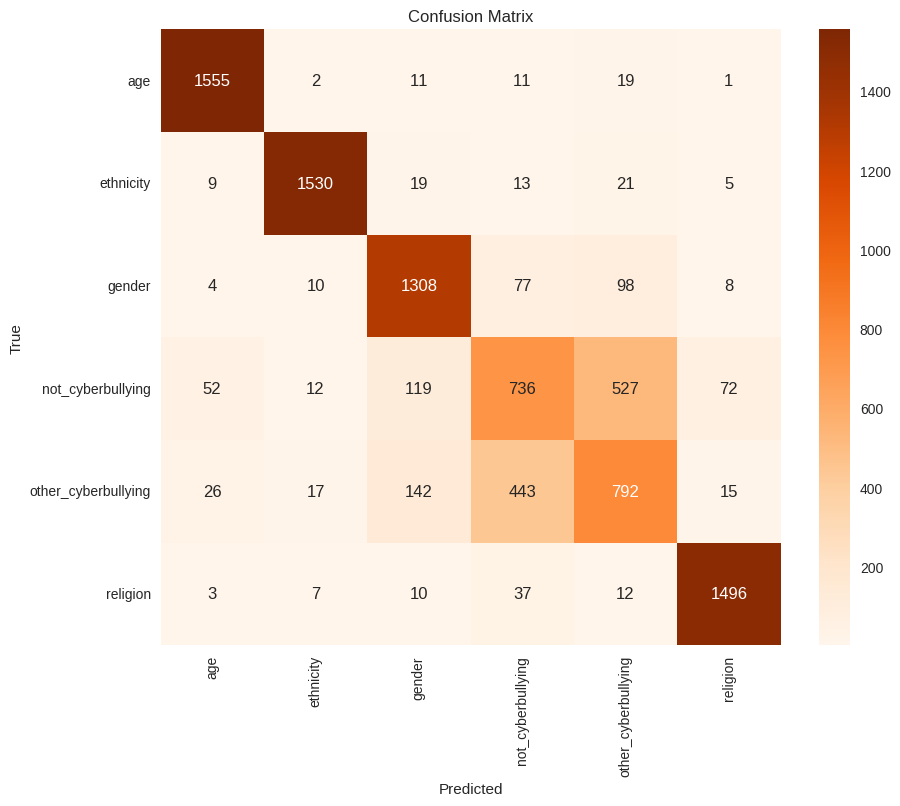

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test_categorical)
print(f"Test Accuracy: {accuracy}")

# Make predictions
predictions_prob_rnn = model.predict(X_test_pad)
predictions_rnn = np.argmax(predictions_prob_rnn, axis=1)

# Get class names from label encoder
class_names = label_encoder.classes_

conf_matrix = confusion_matrix(y_test_encoded, predictions_rnn)

# Confusion Matrix Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Train the model and get the training history
history = model.fit(X_train_pad, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

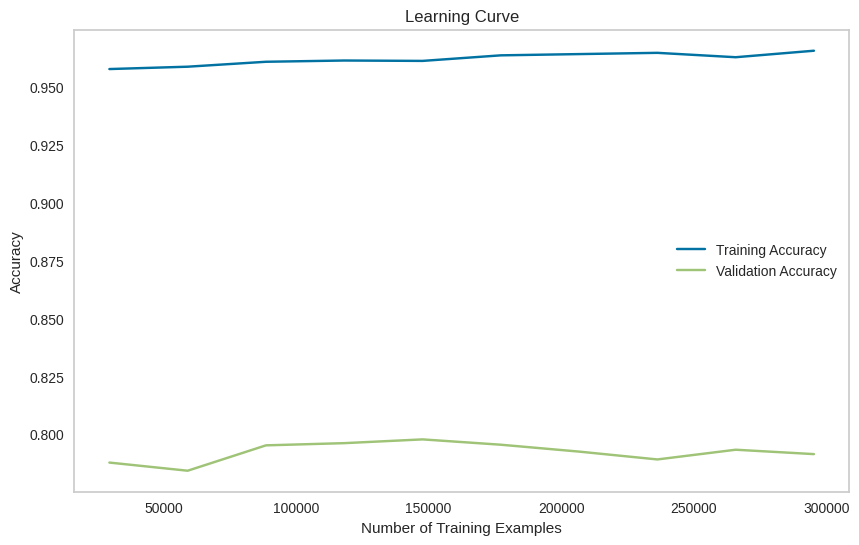

In [ ]:
# Extract accuracy values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the number of training samples
train_sizes = np.arange(1, len(train_accuracy) + 1) * (len(X_train_pad) * 0.8)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_accuracy, label='Training Accuracy')
plt.plot(train_sizes, val_accuracy, label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()